In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold

# visualization
import matplotlib.pyplot as plt

# torch
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Path Setting

In [2]:
IMAGE_ROOT = "/data/ephemeral/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/data/train/outputs_json"

## Load Dataset

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

## Load Prediction

In [4]:
df = pd.read_csv('/data/ephemeral/hbis/logs/upernet_efficientnet-b7_1024_groupnorm_20241121_223652.csv')

In [5]:
len(df.iloc[0]['rle'])

2005

In [6]:
list(pngs)[1].split("/")[1]

image_dict = {name.split("/")[1]:name for name in list(pngs)}
label_dict = {name.split("/")[1][:-4]+'png':name for name in list(jsons)}

df["image_path"] = df['image_name'].apply(lambda x: image_dict[x])
df["label_path"] = df['image_name'].apply(lambda x: label_dict[x])

## Decoding Method (rle to mask)

In [7]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [8]:
def mask_to_poly_seg(mask):
    points = np.argwhere(mask == 1)
    points = points[:, [1, 0]]  # (row, col) => (x, y)
    return points.tolist()

In [9]:
df.head()

,image_name,class,rle,image_path,label_path
0,image1661144206667.png,finger-1,1655328 9 1657372 19 1659417 25 1661462 31 166...,ID002/image1661144206667.png,ID002/image1661144206667.json
1,image1661144206667.png,finger-2,1958500 14 1960542 32 1962586 39 1964631 44 19...,ID002/image1661144206667.png,ID002/image1661144206667.json
2,image1661144206667.png,finger-3,13 12 2061 12 4108 13 6156 14 8204 14 10252 13...,ID002/image1661144206667.png,ID002/image1661144206667.json
3,image1661144206667.png,finger-4,770796 10 772840 18 774885 24 776931 28 778977...,ID002/image1661144206667.png,ID002/image1661144206667.json
4,image1661144206667.png,finger-5,1000244 3 1002289 9 1004335 13 1006382 16 1008...,ID002/image1661144206667.png,ID002/image1661144206667.json


## Load Metadata

In [10]:
meta = pd.read_excel('/data/ephemeral/data/meta_data.xlsx')

meta = meta.drop(columns=["ID", "Unnamed: 5"])

In [11]:
# "남"이 포함되면 "남", "여"가 포함되면 "여"로 설정
meta["성별"] = meta["성별"].apply(lambda x: "남" if "남" in x else ("여" if "여" in x else x))
meta['ID'] = 'ID' + (meta.index + 1).astype(str).str.zfill(3)

meta

,나이,성별,체중(몸무게),키(신장),ID
0,30,여,63.0,165.0,ID001
1,21,남,70.0,172.0,ID002
2,21,여,48.0,164.0,ID003
3,30,여,49.0,158.0,ID004
4,33,여,50.0,160.0,ID005
...,...,...,...,...,...
545,28,여,50.0,158.0,ID546
546,40,남,84.0,175.0,ID547
547,28,여,51.0,165.0,ID548
548,28,남,78.0,175.0,ID549


## Merge Meta data with dataset

In [12]:
# 'ID' 부분만 추출
df['ID'] = 'ID' + df['image_path'].str.extract(r'ID(\d+)')[0]

# meta와 병합
merged_df = df.merge(meta, on="ID", how="inner")

# 결과 확인
print(merged_df.head())


               image_name     class  \
0  image1661144206667.png  finger-1   
1  image1661144206667.png  finger-2   
2  image1661144206667.png  finger-3   
3  image1661144206667.png  finger-4   
4  image1661144206667.png  finger-5   

                                                 rle  \
0  1655328 9 1657372 19 1659417 25 1661462 31 166...   
1  1958500 14 1960542 32 1962586 39 1964631 44 19...   
2  13 12 2061 12 4108 13 6156 14 8204 14 10252 13...   
3  770796 10 772840 18 774885 24 776931 28 778977...   
4  1000244 3 1002289 9 1004335 13 1006382 16 1008...   

                     image_path                     label_path     ID  나이 성별  \
0  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
1  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
2  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
3  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
4  ID002/image1661144206667.

In [13]:
len(merged_df.index)

145

In [14]:
img_names = merged_df['image_name'].unique()
merged_df[merged_df['image_name']==img_names[1]]

,image_name,class,rle,image_path,label_path,ID,나이,성별,체중(몸무게),키(신장)
29,image1661144246917.png,finger-1,1613220 6 1615262 18 1617306 25 1619351 31 162...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
30,image1661144246917.png,finger-2,1918298 4 1920335 18 1922381 23 1924427 27 192...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
31,image1661144246917.png,finger-3,11 17 2059 17 4106 18 6154 18 8202 18 10251 17...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
32,image1661144246917.png,finger-4,806114 8 808157 18 810203 23 812248 28 814295 ...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
33,image1661144246917.png,finger-5,1057965 7 1060011 20 1062057 25 1064104 29 106...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
34,image1661144246917.png,finger-6,1383563 12 1385598 28 1387644 33 1389691 36 13...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
35,image1661144246917.png,finger-7,1952849 13 1954894 23 1956939 29 1958982 36 19...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
36,image1661144246917.png,finger-8,639941 10 641983 21 644028 27 646074 31 648120...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
37,image1661144246917.png,finger-9,920497 3 922542 10 922592 9 924585 18 924635 1...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0
38,image1661144246917.png,finger-10,110592 1 112639 2 114686 3 116734 3 118781 4 1...,ID002/image1661144246917.png,ID002/image1661144246917.json,ID002,21,남,70.0,172.0


## Validation Dataset에 대해 over & under ratio 계산

In [15]:
def calculate_over_under_predict_ratio(df):
    # 오버/언더 예측 값들을 저장할 딕셔너리
    total_class_metrics = {class_name: {"gt_pixels": 0, "over_pixels": 0, "under_pixels": 0} for class_name in CLASSES}
    image_metrics = []  # 각 이미지별 metrics를 저장할 리스트

    img_names = df['image_name'].unique()  # 이미지 이름 목록을 먼저 추출
    
    # tqdm을 사용하여 진행 상황 표시
    for idx in tqdm(range(len(img_names)), desc="Processing images", unit="image"):  # 진행 상태 표시 추가
        df_ = df[df['image_name'] == img_names[idx]]  # 해당 이미지에 대한 df 필터링

        label_path = df_['label_path'].iloc[0]

        # (H, W, NC) 모양의 label을 생성합니다. 이미지 크기에 맞춰서 gt_label 크기만 잡고
        # label을 계산하는 부분만 유지합니다.
        gt_label = None
        with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # GT 라벨 생성
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # GT 크기만큼 label을 채우는 방식으로 진행
            if gt_label is None:
                # 이미지 크기만큼 GT 라벨 배열을 초기화
                sample_image = np.zeros((2048, 2048, len(CLASSES)), dtype=np.uint8)  # 임시 크기로 설정 (예: 1000x1000)
                gt_label = np.zeros(sample_image.shape[:2] + (len(CLASSES),), dtype=np.uint8)

            class_label = np.zeros(gt_label.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            gt_label[..., class_ind] = class_label

            # GT 크기 누적
            total_class_metrics[CLASSES[class_ind]]["gt_pixels"] += np.sum(class_label)

        pred_label = np.zeros_like(gt_label, dtype=np.uint8)
        for _, row in df_.iterrows():
            c = row['class']
            class_ind = CLASS2IND[c]
            rle = row['rle']
            mask = rle_to_mask(rle, gt_label.shape[0], gt_label.shape[1])
            pred_label[..., class_ind] = mask

        # 각 클래스에 대해 Over/Under-Prediction 계산
        over_prediction = np.zeros_like(gt_label, dtype=np.uint8)
        under_prediction = np.zeros_like(gt_label, dtype=np.uint8)

        for class_ind in range(len(CLASSES)):
            over_prediction[..., class_ind] = (pred_label[..., class_ind] > gt_label[..., class_ind]).astype(np.uint8)
            under_prediction[..., class_ind] = (pred_label[..., class_ind] < gt_label[..., class_ind]).astype(np.uint8)

            over_pixels = np.sum(over_prediction[..., class_ind])
            under_pixels = np.sum(under_prediction[..., class_ind])

            total_class_metrics[CLASSES[class_ind]]["over_pixels"] += over_pixels
            total_class_metrics[CLASSES[class_ind]]["under_pixels"] += under_pixels

        # 각 이미지에 대한 비율 계산
        image_over_ratio = {}
        image_under_ratio = {}

        for class_name, metrics in total_class_metrics.items():
            gt_pixels = metrics["gt_pixels"]
            over_pixels = metrics["over_pixels"]
            under_pixels = metrics["under_pixels"]

            image_over_ratio[class_name] = over_pixels / gt_pixels if gt_pixels > 0 else 0
            image_under_ratio[class_name] = under_pixels / gt_pixels if gt_pixels > 0 else 0

        # 이미지에 대한 비율 저장
        image_metrics.append({
            "image_name": img_names[idx],
            "over_ratio": image_over_ratio,
            "under_ratio": image_under_ratio
        })

    # 이미지별 오버/언더 비율 결과를 반환
    return image_metrics

In [16]:
image_metrics = calculate_over_under_predict_ratio(df)

Processing images: 100%|██████████| 5/5 [00:25<00:00,  5.14s/image]


In [17]:
image_metrics

[{'image_name': 'image1661144206667.png',
  'over_ratio': {'finger-1': 0.9469753547423451,
   'finger-2': 0.41820720469142697,
   'finger-3': 0.4342730753994454,
   'finger-4': 0.7573421439060205,
   'finger-5': 0.5570764236202509,
   'finger-6': 0.4108032179798238,
   'finger-7': 0.3753864038680018,
   'finger-8': 0.6586595492289442,
   'finger-9': 0.5645161290322581,
   'finger-10': 0.3853340253577519,
   'finger-11': 0.293442015561319,
   'finger-12': 0.6882716049382716,
   'finger-13': 0.4586903076808463,
   'finger-14': 0.4343530223928895,
   'finger-15': 0.3930967191120868,
   'finger-16': 0.9449732992802414,
   'finger-17': 0.5655556996498509,
   'finger-18': 0.7084590163934427,
   'finger-19': 0.4279302291636258,
   'Trapezium': 0.15882956878850102,
   'Trapezoid': 0.008679567444507683,
   'Capitate': 0.0019079418077748629,
   'Hamate': 0.14926355632354152,
   'Scaphoid': 0.03713138798826617,
   'Lunate': 0.13165839982747465,
   'Triquetrum': 0.24398470879244435,
   'Pisiform':

In [18]:
merged_df

,image_name,class,rle,image_path,label_path,ID,나이,성별,체중(몸무게),키(신장)
0,image1661144206667.png,finger-1,1655328 9 1657372 19 1659417 25 1661462 31 166...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,남,70.0,172.0
1,image1661144206667.png,finger-2,1958500 14 1960542 32 1962586 39 1964631 44 19...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,남,70.0,172.0
2,image1661144206667.png,finger-3,13 12 2061 12 4108 13 6156 14 8204 14 10252 13...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,남,70.0,172.0
3,image1661144206667.png,finger-4,770796 10 772840 18 774885 24 776931 28 778977...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,남,70.0,172.0
4,image1661144206667.png,finger-5,1000244 3 1002289 9 1004335 13 1006382 16 1008...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,남,70.0,172.0
...,...,...,...,...,...,...,...,...,...,...
140,image1661216747360.png,Lunate,3281897 2 3283942 7 3285988 10 3288032 15 3290...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,남,65.0,178.0
141,image1661216747360.png,Triquetrum,3148918 8 3150955 4 3150960 16 3153000 25 3155...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,남,65.0,178.0
142,image1661216747360.png,Pisiform,3302508 2 3304532 28 3306576 36 3308622 41 331...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,남,65.0,178.0
143,image1661216747360.png,Radius,3296031 9 3298077 14 3300123 18 3302169 21 330...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,남,65.0,178.0


In [19]:
def add_over_under_to_merged_df(merged_df, image_metrics):
    # image_metrics에서 각 이미지의 over_ratio와 under_ratio를 가져와서 merged_df에 추가
    for metrics in tqdm(image_metrics, desc="Updating merged_df", unit="image"):
        image_name = metrics['image_name']
        over_ratio = metrics['over_ratio']
        under_ratio = metrics['under_ratio']

        # 각 클래스에 대해 over_ratio와 under_ratio 값을 merged_df에 업데이트
        for class_name in CLASSES:
            # 해당 class_name에 대한 over_ratio와 under_ratio 값을 가져옴
            over_value = over_ratio.get(class_name, 0)
            under_value = under_ratio.get(class_name, 0)

            # 해당 image_name과 class_name에 맞는 row에서 over_ratio, under_ratio 업데이트
            merged_df.loc[
                (merged_df['image_name'] == image_name) & (merged_df['class'] == class_name),
                'over_ratio'
            ] = over_value

            merged_df.loc[
                (merged_df['image_name'] == image_name) & (merged_df['class'] == class_name),
                'under_ratio'
            ] = under_value



In [20]:
add_over_under_to_merged_df(merged_df, image_metrics)

Updating merged_df: 100%|██████████| 5/5 [00:00<00:00, 20.12image/s]


In [21]:
print(merged_df.head())

               image_name     class  \
0  image1661144206667.png  finger-1   
1  image1661144206667.png  finger-2   
2  image1661144206667.png  finger-3   
3  image1661144206667.png  finger-4   
4  image1661144206667.png  finger-5   

                                                 rle  \
0  1655328 9 1657372 19 1659417 25 1661462 31 166...   
1  1958500 14 1960542 32 1962586 39 1964631 44 19...   
2  13 12 2061 12 4108 13 6156 14 8204 14 10252 13...   
3  770796 10 772840 18 774885 24 776931 28 778977...   
4  1000244 3 1002289 9 1004335 13 1006382 16 1008...   

                     image_path                     label_path     ID  나이 성별  \
0  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
1  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
2  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
3  ID002/image1661144206667.png  ID002/image1661144206667.json  ID002  21  남   
4  ID002/image1661144206667.

In [22]:
merged_df = merged_df.rename(columns={'나이': 'age', '성별': 'gender', '체중(몸무게)': 'weight', '키(신장)': 'height'})

In [23]:
merged_df['gender'] = merged_df['gender'].map({'남': 1, '여': 0})
merged_df

,image_name,class,rle,image_path,label_path,ID,age,gender,weight,height,over_ratio,under_ratio
0,image1661144206667.png,finger-1,1655328 9 1657372 19 1659417 25 1661462 31 166...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,1,70.0,172.0,0.946975,0.028379
1,image1661144206667.png,finger-2,1958500 14 1960542 32 1962586 39 1964631 44 19...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,1,70.0,172.0,0.418207,0.015526
2,image1661144206667.png,finger-3,13 12 2061 12 4108 13 6156 14 8204 14 10252 13...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,1,70.0,172.0,0.434273,0.018058
3,image1661144206667.png,finger-4,770796 10 772840 18 774885 24 776931 28 778977...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,1,70.0,172.0,0.757342,0.000000
4,image1661144206667.png,finger-5,1000244 3 1002289 9 1004335 13 1006382 16 1008...,ID002/image1661144206667.png,ID002/image1661144206667.json,ID002,21,1,70.0,172.0,0.557076,0.012898
...,...,...,...,...,...,...,...,...,...,...,...,...
140,image1661216747360.png,Lunate,3281897 2 3283942 7 3285988 10 3288032 15 3290...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,1,65.0,178.0,0.121164,0.146994
141,image1661216747360.png,Triquetrum,3148918 8 3150955 4 3150960 16 3153000 25 3155...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,1,65.0,178.0,0.257086,0.137487
142,image1661216747360.png,Pisiform,3302508 2 3304532 28 3306576 36 3308622 41 331...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,1,65.0,178.0,0.201635,0.614728
143,image1661216747360.png,Radius,3296031 9 3298077 14 3300123 18 3302169 21 330...,ID013/image1661216747360.png,ID013/image1661216747360.json,ID013,29,1,65.0,178.0,0.203529,0.024310


In [24]:
nan_count = merged_df.isna().sum()
print(nan_count)

image_name     0
class          0
rle            0
image_path     0
label_path     0
ID             0
age            0
gender         0
weight         0
height         0
over_ratio     0
under_ratio    0
dtype: int64


## 이미지 당 각 클래스별 over_ratio, under_ratio를 평균내어 재구성

In [25]:
# 각 이미지에 대해 각 클래스의 평균 over_ratio, under_ratio 계산
class_avg_df = (
    merged_df.groupby(['image_name', 'class'])[['over_ratio', 'under_ratio']]
    .mean()
    .reset_index()
)

# 각 이미지에 대해 전체 클래스의 평균 over_ratio, under_ratio 계산
image_avg_df = (
    class_avg_df.groupby('image_name')[['over_ratio', 'under_ratio']]
    .mean()
    .reset_index()
)

# 이미지 메타 데이터 (age, gender, weight, height)를 유지
meta_columns = ['image_name', 'age', 'gender', 'weight', 'height']
meta_df = merged_df[meta_columns].drop_duplicates()

# 평균 데이터와 메타 데이터를 병합
result_df = image_avg_df.merge(meta_df, on='image_name', how='left')

# 결과 확인
print(result_df.head())


               image_name  over_ratio  under_ratio  age  gender  weight  \
0  image1661144206667.png    0.410811     0.083160   21       1    70.0   
1  image1661144246917.png    0.407563     0.085464   21       1    70.0   
2  image1661145193855.png    0.431925     0.076846   39       0    52.0   
3  image1661145229731.png    0.445686     0.073361   39       0    52.0   
4  image1661216747360.png    0.441139     0.073196   29       1    65.0   

   height  
0   172.0  
1   172.0  
2   165.0  
3   165.0  
4   178.0  


## 상관 관계 분석

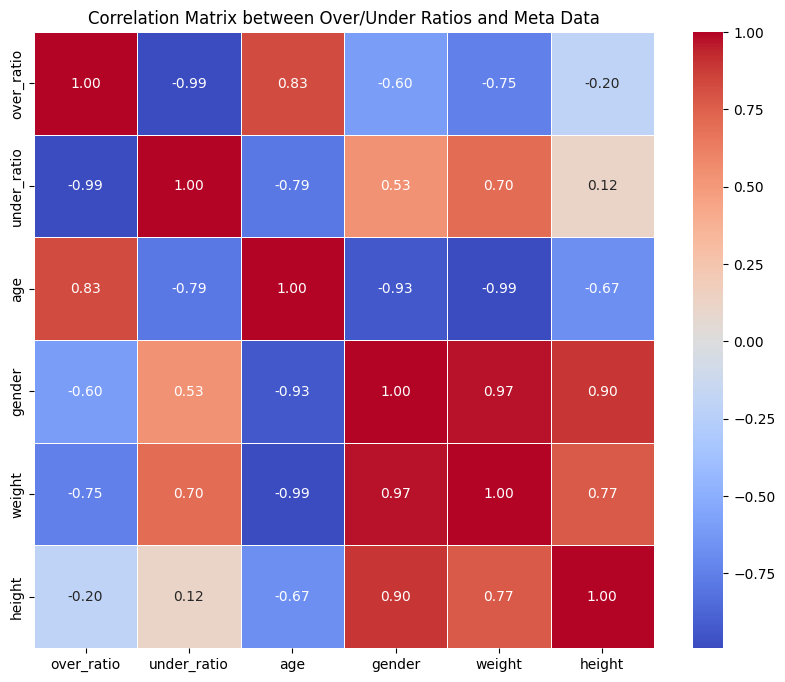

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'over_ratio', 'under_ratio'와 'age', 'gender', 'weight', 'height'의 상관계수 계산
correlation_cols = ['over_ratio', 'under_ratio', 'age', 'gender', 'weight', 'height']
correlation_matrix = result_df[correlation_cols].corr()

# 상관 관계 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix between Over/Under Ratios and Meta Data')
plt.show()


In [27]:
result_df

,image_name,over_ratio,under_ratio,age,gender,weight,height
0,image1661144206667.png,0.410811,0.083160,21,1,70.0,172.0
1,image1661144246917.png,0.407563,0.085464,21,1,70.0,172.0
2,image1661145193855.png,0.431925,0.076846,39,0,52.0,165.0
3,image1661145229731.png,0.445686,0.073361,39,0,52.0,165.0
4,image1661216747360.png,0.441139,0.073196,29,1,65.0,178.0


## 나이

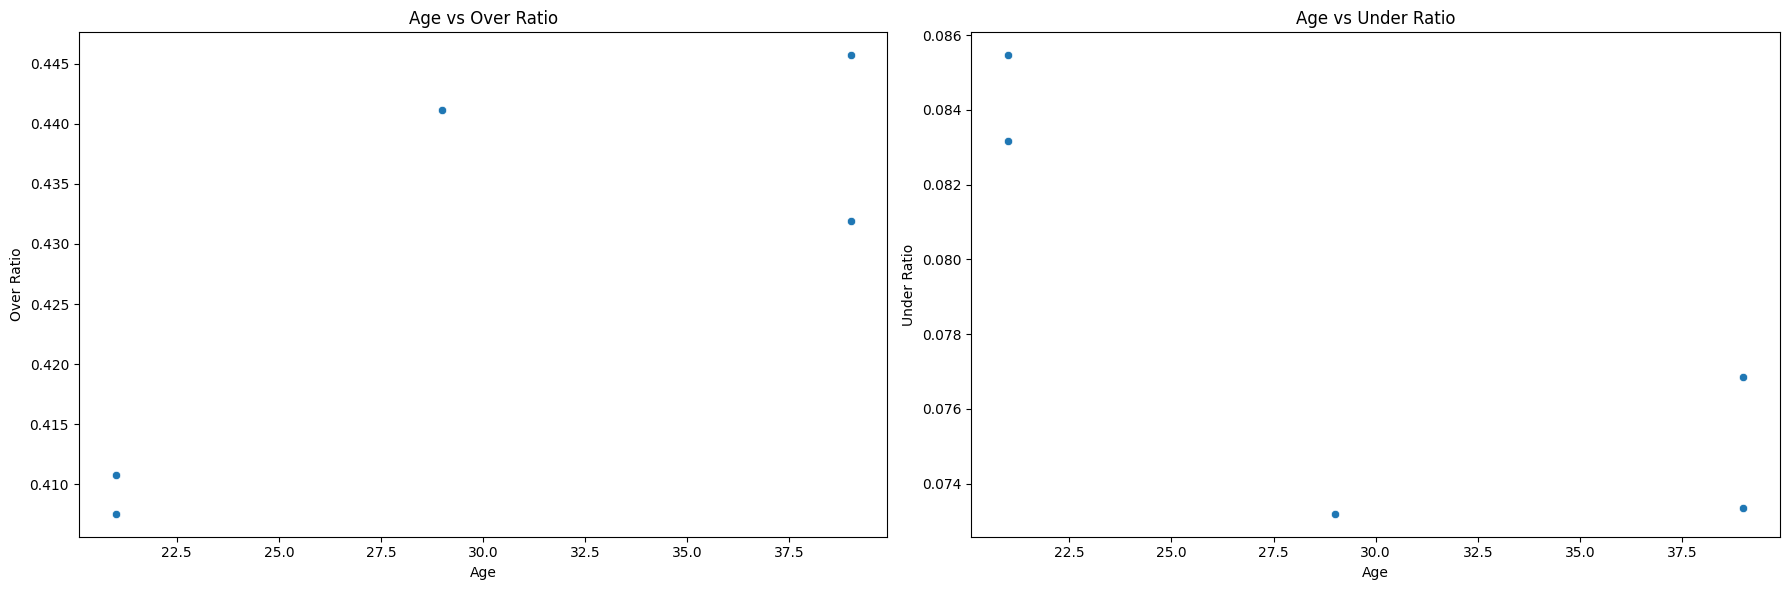

In [28]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 첫 번째 서브 플롯: age vs over_ratio
sns.scatterplot(x=result_df['age'], y=result_df['over_ratio'], ax=axes[0])
axes[0].set_title('Age vs Over Ratio')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Over Ratio')

# 두 번째 서브 플롯: age vs under_ratio
sns.scatterplot(x=result_df['age'], y=result_df['under_ratio'], ax=axes[1])
axes[1].set_title('Age vs Under Ratio')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Under Ratio')

# 레이아웃 조정
plt.tight_layout()
plt.show()


## 성별

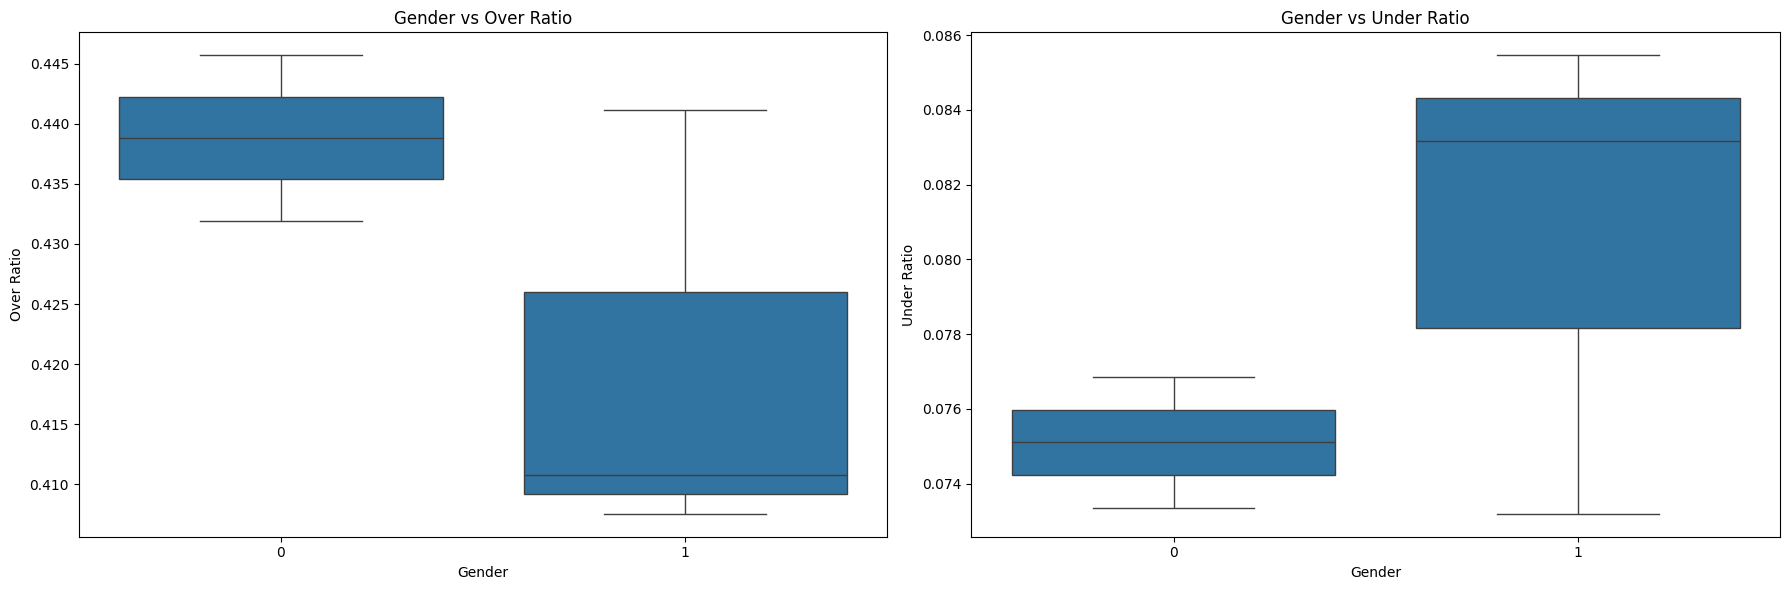

In [29]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 첫 번째 서브 플롯: age vs over_ratio
sns.boxplot(x=result_df['gender'], y=result_df['over_ratio'], ax=axes[0])
axes[0].set_title('Gender vs Over Ratio')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Over Ratio')

# 두 번째 서브 플롯: age vs under_ratio
sns.boxplot(x=result_df['gender'], y=result_df['under_ratio'], ax=axes[1])
axes[1].set_title('Gender vs Under Ratio')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Under Ratio')

# 레이아웃 조정
plt.tight_layout()
plt.show()


## 키 & 몸무게

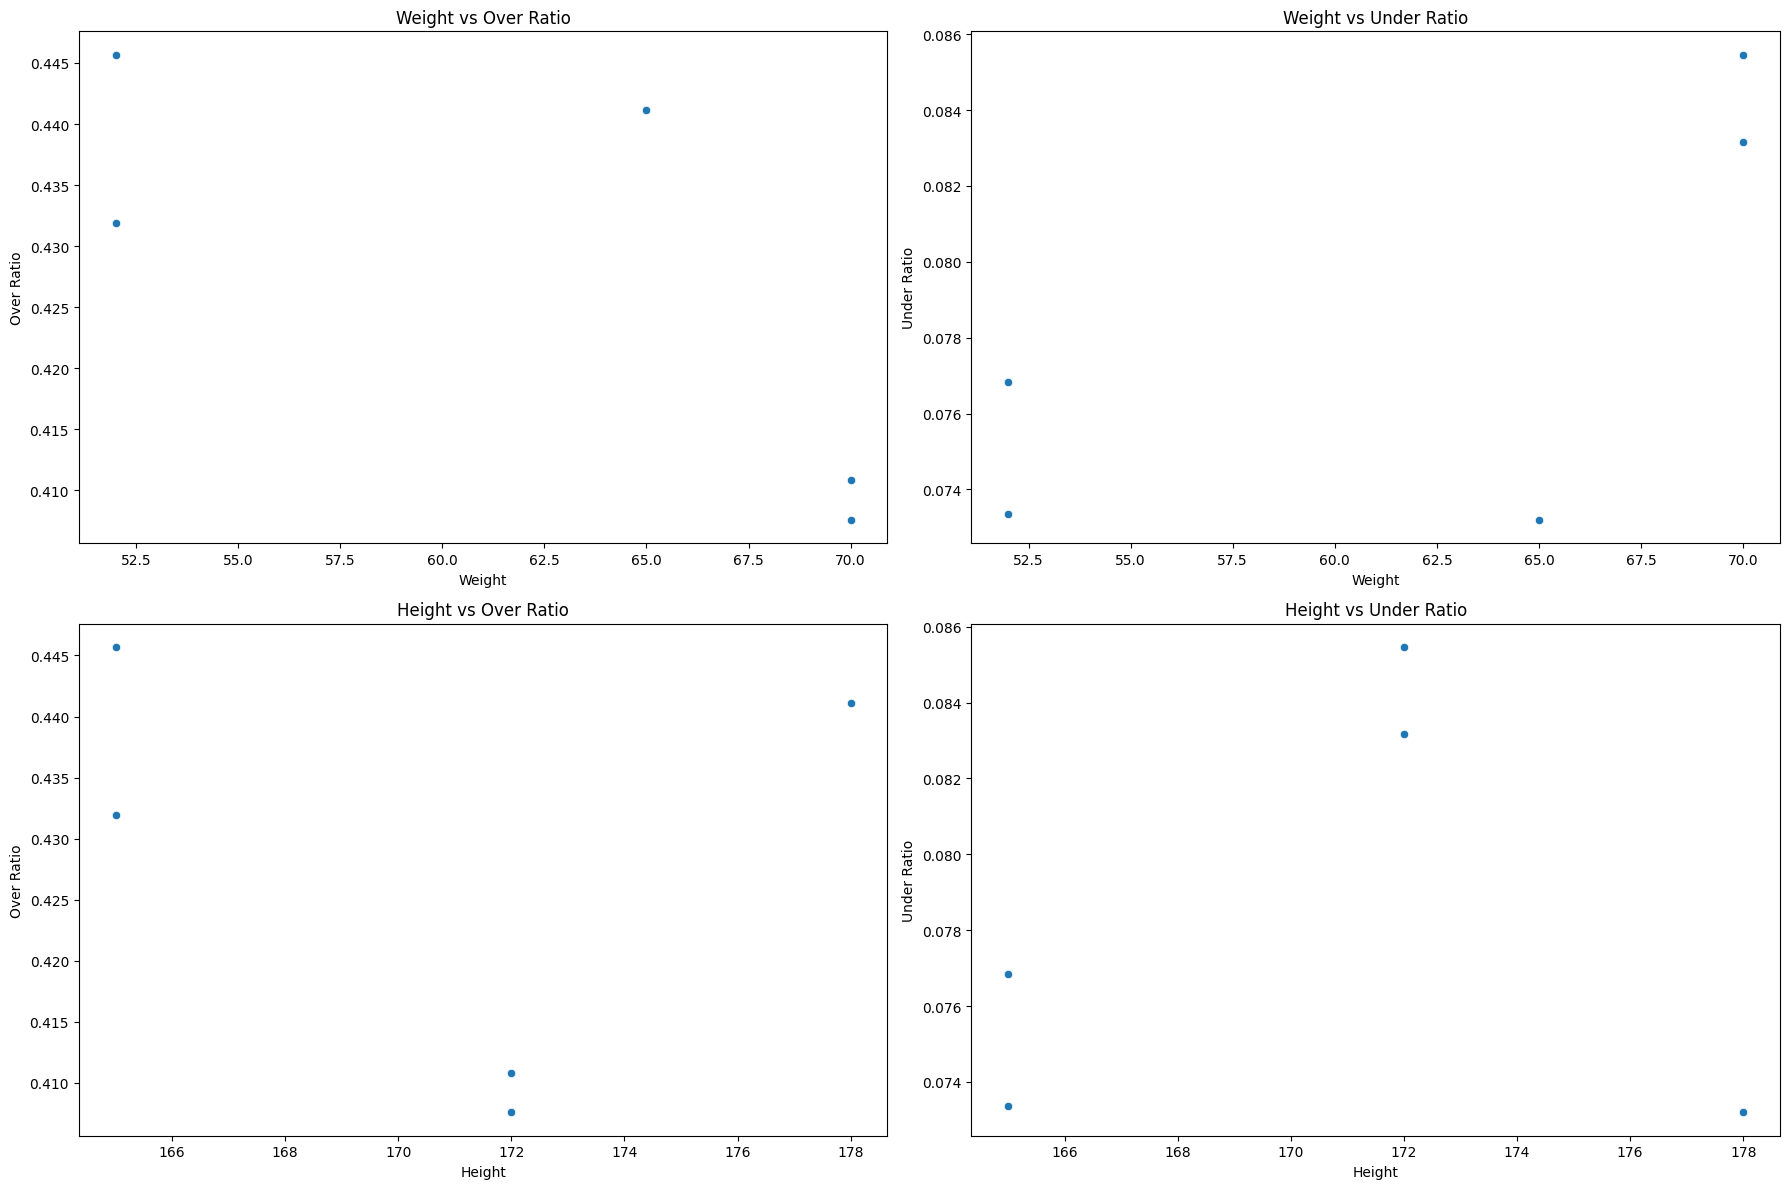

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 첫 번째 서브 플롯: weight vs over_ratio
sns.scatterplot(x=result_df['weight'], y=result_df['over_ratio'], ax=axes[0, 0])
axes[0, 0].set_title('Weight vs Over Ratio')
axes[0, 0].set_xlabel('Weight')
axes[0, 0].set_ylabel('Over Ratio')

# 두 번째 서브 플롯: weight vs under_ratio
sns.scatterplot(x=result_df['weight'], y=result_df['under_ratio'], ax=axes[0, 1])
axes[0, 1].set_title('Weight vs Under Ratio')
axes[0, 1].set_xlabel('Weight')
axes[0, 1].set_ylabel('Under Ratio')

# 세 번째 서브 플롯: height vs over_ratio
sns.scatterplot(x=result_df['height'], y=result_df['over_ratio'], ax=axes[1, 0])
axes[1, 0].set_title('Height vs Over Ratio')
axes[1, 0].set_xlabel('Height')
axes[1, 0].set_ylabel('Over Ratio')

# 네 번째 서브 플롯: height vs under_ratio
sns.scatterplot(x=result_df['height'], y=result_df['under_ratio'], ax=axes[1, 1])
axes[1, 1].set_title('Height vs Under Ratio')
axes[1, 1].set_xlabel('Height')
axes[1, 1].set_ylabel('Under Ratio')

# 레이아웃 조정
plt.tight_layout()
plt.show()


## 설마 BMI?

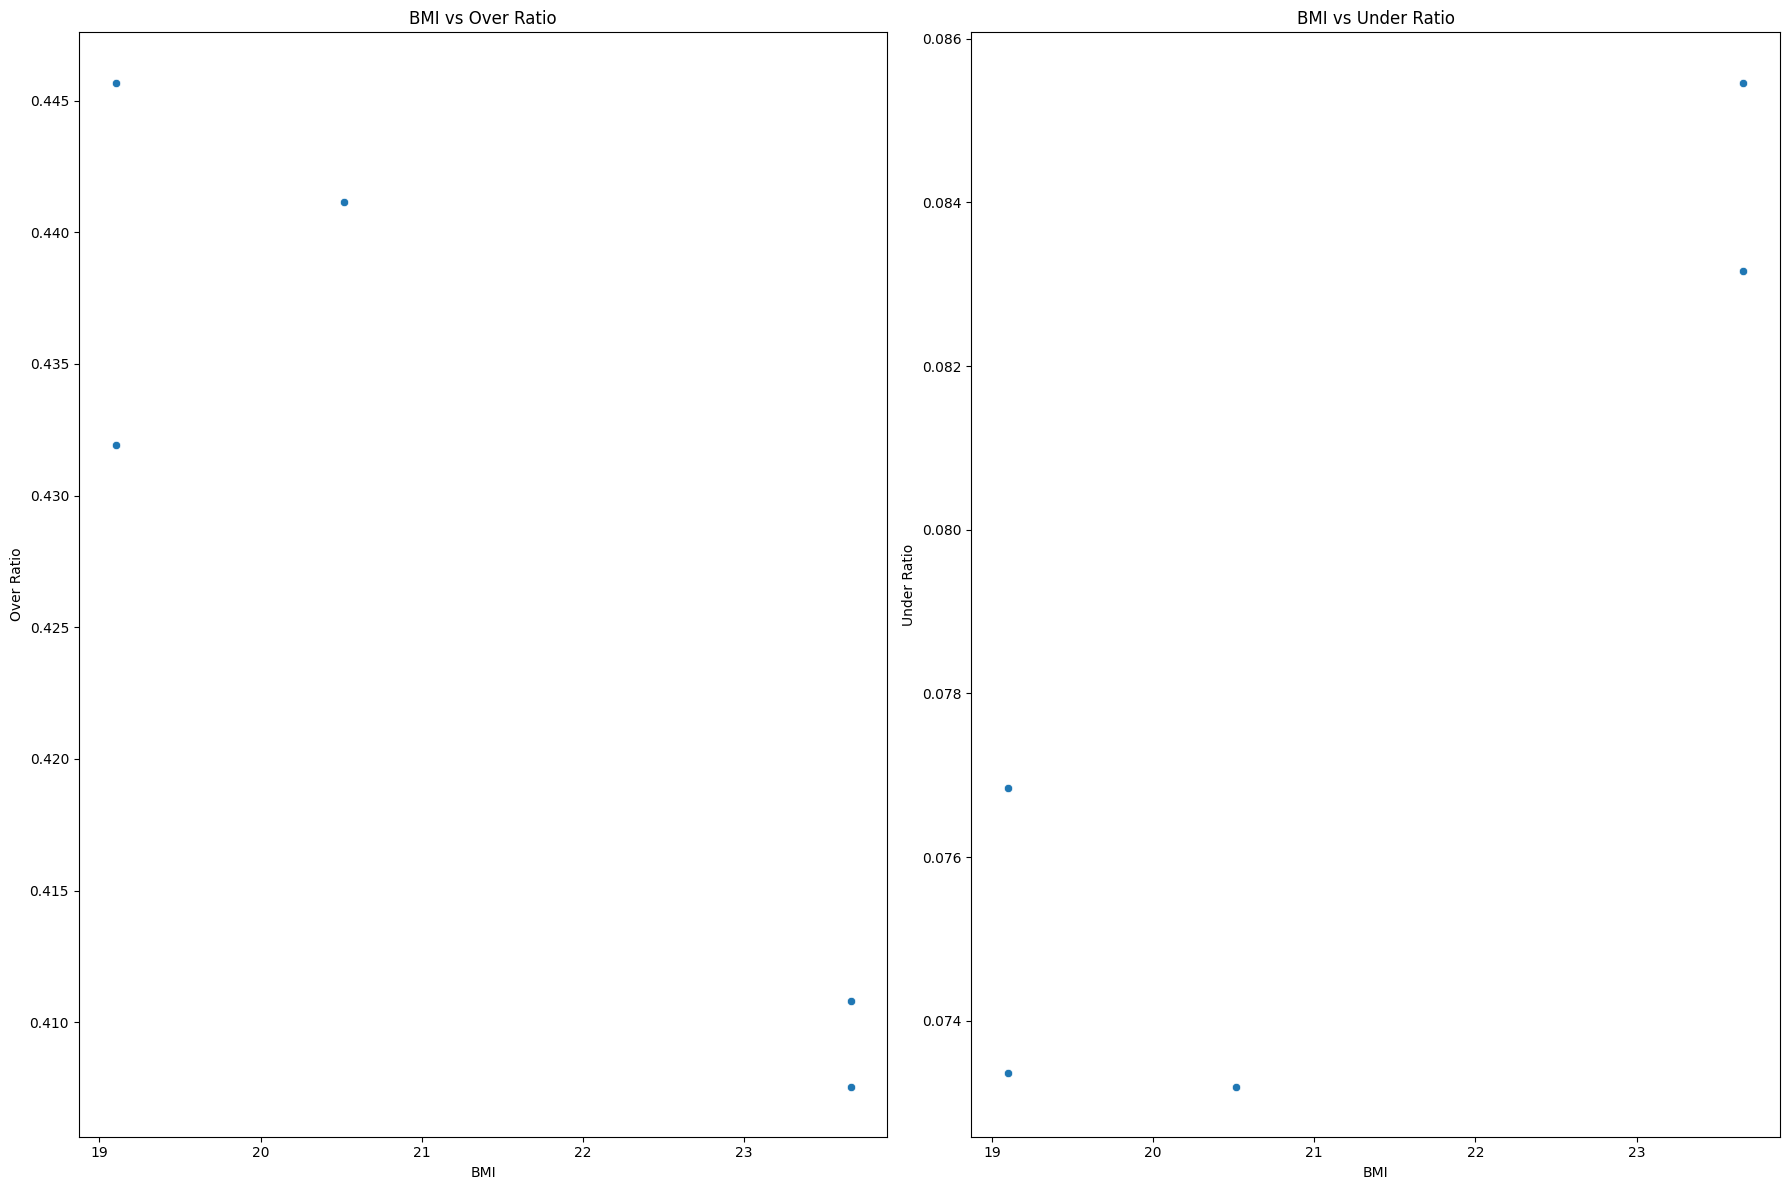

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# BMI 계산 (weight는 kg, height는 cm로 가정하고 height를 미터로 변환)
result_df['bmi'] = result_df['weight'] / (result_df['height'] / 100)**2

# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 첫 번째 서브 플롯: bmi vs over_ratio
sns.scatterplot(x=result_df['bmi'], y=result_df['over_ratio'], ax=axes[0])
axes[0].set_title('BMI vs Over Ratio')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Over Ratio')

# 두 번째 서브 플롯: bmi vs under_ratio
sns.scatterplot(x=result_df['bmi'], y=result_df['under_ratio'], ax=axes[1])
axes[1].set_title('BMI vs Under Ratio')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Under Ratio')

# 레이아웃 조정
plt.tight_layout()
plt.show()


## 클래스 별 over & under 상관 관계 분석 -- threshold 클래스 별로 적용하기 위한 분석

In [32]:
# 각 클래스별로 over_ratio와 under_ratio의 평균값을 구하기
class_avg_df = merged_df.groupby('class')[['over_ratio', 'under_ratio']].mean().reset_index()

# 새로운 DataFrame 확인
print(class_avg_df)


         class  over_ratio  under_ratio
0     Capitate    0.010359     0.158358
1       Hamate    0.108785     0.128597
2       Lunate    0.119517     0.156022
3     Pisiform    0.182980     0.664708
4       Radius    0.202129     0.025730
5     Scaphoid    0.048096     0.192709
6    Trapezium    0.161418     0.197672
7    Trapezoid    0.009753     0.394064
8   Triquetrum    0.249310     0.132997
9         Ulna    0.427277     0.002047
10    finger-1    0.882795     0.022294
11   finger-10    0.409081     0.001244
12   finger-11    0.334546     0.017005
13   finger-12    0.733917     0.000000
14   finger-13    0.614026     0.011128
15   finger-14    0.467888     0.002836
16   finger-15    0.387919     0.030034
17   finger-16    0.941369     0.000000
18   finger-17    0.640535     0.027806
19   finger-18    0.670597     0.003963
20   finger-19    0.464613     0.034051
21    finger-2    0.444753     0.015243
22    finger-3    0.409575     0.012958
23    finger-4    0.769193     0.000000


/tmp/ipykernel_3162598/2544577245.py:28: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3162598/2544577245.py:28: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3162598/2544577245.py:28: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaV

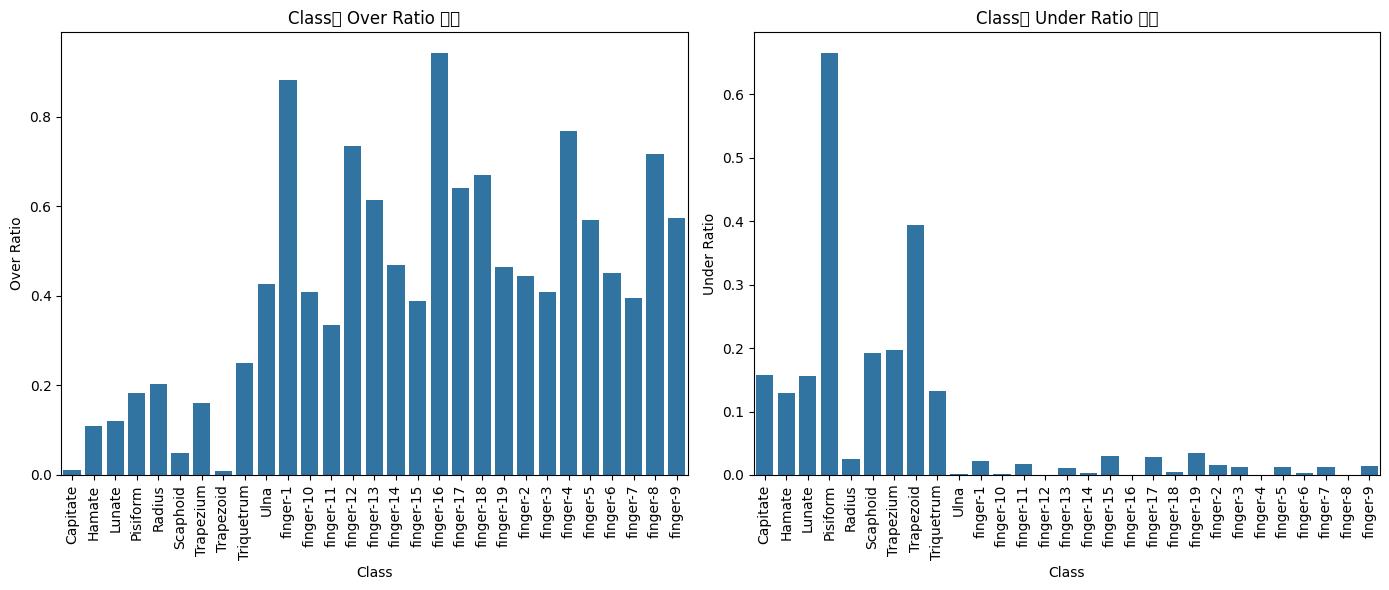

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

y_min, y_max = 0, 2  # 데이터에 맞게 조정

# Barplot으로 시각화 (over_ratio와 under_ratio)
plt.figure(figsize=(14, 6))

# over_ratio 시각화
plt.subplot(1, 2, 1)
sns.barplot(x='class', y='over_ratio', data=class_avg_df)
plt.title('Class별 Over Ratio 평균')
plt.xlabel('Class')
plt.ylabel('Over Ratio')

# x축 라벨 회전
plt.xticks(rotation=90)
plt.ylim(y_min, y_max)  # y축 범위 설정

# under_ratio 시각화
plt.subplot(1, 2, 2)
sns.barplot(x='class', y='under_ratio', data=class_avg_df)
plt.title('Class별 Under Ratio 평균')
plt.xlabel('Class')
plt.ylabel('Under Ratio')

# x축 라벨 회전
plt.xticks(rotation=90)
plt.ylim(y_min, y_max)  # 동일한 y축 범위 설정

# 레이아웃 조정
plt.tight_layout()
plt.show()


In [34]:
import scipy.stats as stats
# 원본 데이터에서 각 클래스별로 over_ratio, under_ratio 값을 추출
f_stat_over, p_val_over = stats.f_oneway(
    *[merged_df[merged_df['class'] == c]['over_ratio'] for c in merged_df['class'].unique()]
)
f_stat_under, p_val_under = stats.f_oneway(
    *[merged_df[merged_df['class'] == c]['under_ratio'] for c in merged_df['class'].unique()]
)

# 결과 출력
print(f"ANOVA 결과 - Over Ratio: F-statistic={f_stat_over}, p-value={p_val_over}")
print(f"ANOVA 결과 - Under Ratio: F-statistic={f_stat_under}, p-value={p_val_under}")


ANOVA 결과 - Over Ratio: F-statistic=311.89406649170513, p-value=3.232871698742058e-96
ANOVA 결과 - Under Ratio: F-statistic=195.8712193001862, p-value=9.771363485057253e-85
